In [53]:
import pandas as pd
import sqlite3

#### Подключение к базе данных

In [54]:
try:
    conn = sqlite3.connect('../data/checking-logs.sqlite')
    print("Успешное подключение к базе данных.")
except sqlite3.Error as e:
    print(f"Ошибка при подключении к базе данных: {e}")
    exit()

Успешное подключение к базе данных.


#### Даты, когда были и просмотры, и коммиты checker

In [55]:
query_commits = "SELECT uid, timestamp FROM checker WHERE uid LIKE 'user_%'"
commits = pd.read_sql_query(query_commits, conn, parse_dates=['timestamp'])
commits

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


#### Определяем выходной день или выходной

In [56]:
commits['weekday'] = commits['timestamp'].dt.day_name()
commits['hour'] = commits['timestamp'].dt.hour
commits['day'] = commits['timestamp'].dt.day
commits['is_weekend'] = commits['weekday'].isin(['Saturday', 'Sunday'])
commits['type'] = commits['is_weekend'].apply(lambda x: 'working_day' if x == False else 'weekend')
commits = commits.drop(columns=['is_weekend'])
commits

,uid,timestamp,weekday,hour,day,type
0,user_4,2020-04-17 05:19:02.744528,Friday,5,17,working_day
1,user_4,2020-04-17 05:22:35.249331,Friday,5,17,working_day
2,user_4,2020-04-17 05:22:45.549397,Friday,5,17,working_day
3,user_4,2020-04-17 05:34:14.691200,Friday,5,17,working_day
4,user_4,2020-04-17 05:34:24.422370,Friday,5,17,working_day
...,...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,Thursday,20,21,working_day
3203,user_1,2020-05-21 20:22:41.785725,Thursday,20,21,working_day
3204,user_1,2020-05-21 20:22:41.877806,Thursday,20,21,working_day
3205,user_1,2020-05-21 20:37:00.129678,Thursday,20,21,working_day


In [57]:
commits_groupped = commits.groupby(['type', 'day', 'hour']).count()
commits_groupped = commits_groupped.groupby(
    ['type', 'hour']).mean()['uid'].reset_index()
commits_groupped = commits_groupped.pivot(columns='type', values='uid', index='hour')

new_index = pd.Index(range(24))
commits_groupped = commits_groupped.reindex(new_index)

commits_groupped

type,weekend,working_day
0,2.000000,3.000000
1,6.000000,NaN
2,NaN,NaN
3,1.000000,2.000000
4,NaN,NaN
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000


### Построение графика

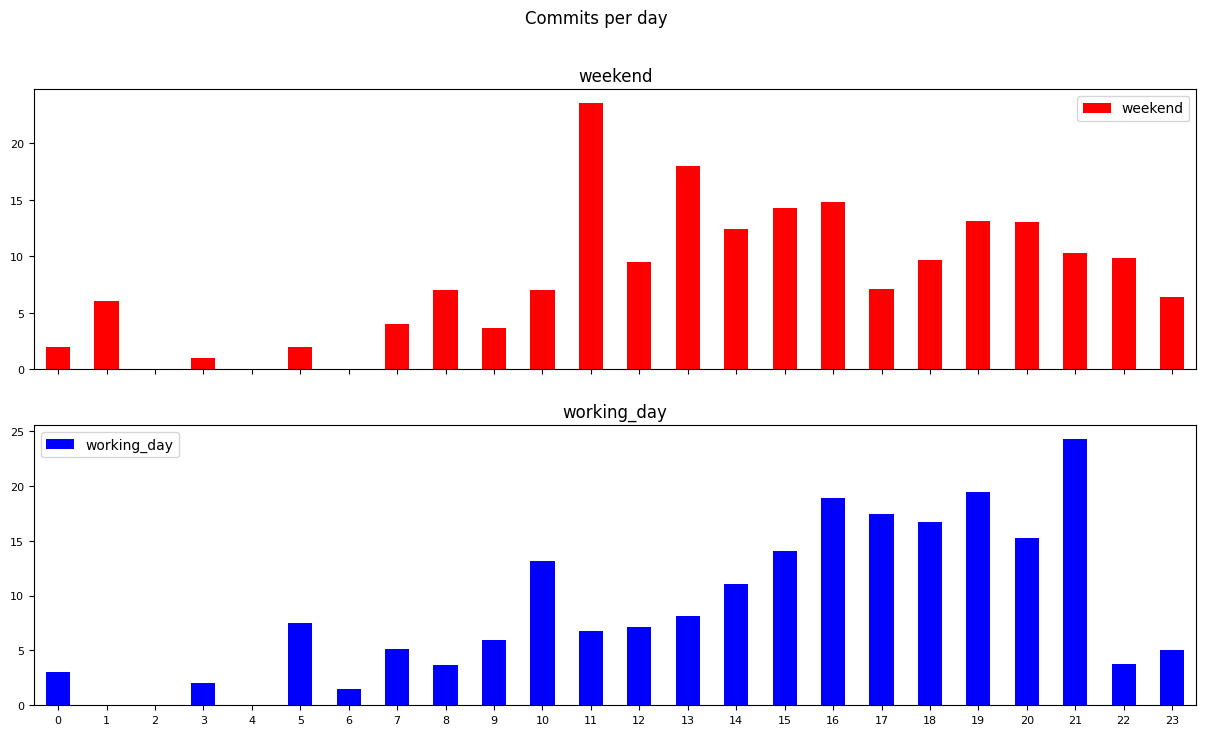

In [58]:
ax = commits_groupped.plot(kind='bar', stacked=True,
            figsize=(15,8), title='Commits per day',
            color=['r', 'b'], rot=0, fontsize=8,
            subplots=True)

### Отличается ли динамика в рабочие и выходные дни?

In [59]:
max_hour_weekend = commits_groupped['weekend'].idxmax()
max_hour_working_day = commits_groupped['working_day'].idxmax()
print(f'Max commits in working day {max_hour_working_day}')
print(f'Max commits in weekend {max_hour_weekend}')

Max commits in working day 21
Max commits in weekend 11


#### Вывод: динамика в рабочие и выходные дни отличается.

#### Закрытие соединения

In [60]:
conn.close()